# Stock Sentiment Analysis from News Headlines

<p>This notebook generates investing insights by applying sentiment analysis on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using a natural language processing< technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. This enables us to make educated guesses on how certain stocks will perform and trade accordingly.</p>

<p>Why headlines? And why from FINVIZ?</p>
FinViz makes market information accessible and provides a lot of data in visual snapshots.
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. <b>Consistent textual patterns will improve the sentiment analysis.</b></li>
</ol>
<br>
<p><strong>Disclaimer: Investing in the stock market involves risk and can lead to monetary loss. The content in this notebook is purely for educational purposes and should not to be taken as financial advice.</strong> </p>

In [53]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
%matplotlib inline
# https://github.com/mariostoev/finviz
import finviz
import nltk
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [42]:
# Tickers of Stocks we want to investigate
TICKER_LIST = ['AMZN', 'GOOG']

## finviz-api

We will be using an unofficial [finviz-API](https://github.com/mariostoev/finviz) made by [Mario Stoev](https://github.com/mariostoev) to get the news headlines for each stock.

finviz.get_news returns list of sets containing containing:
1. Datetime
2. Headline
3. URL
4. Source

In [43]:
def get_news(ticker):
    """
    Returns a list of sets containing news headline and url
    
    :param ticker: stock symbol
    :return: list
    """
    news = finviz.get_news(ticker)
    return news

In [44]:
# Example
e = get_news('AAPL')[0][0]
datetime.strptime(e, '%Y-%m-%d %H:%M').time()

datetime.time(8, 4)

In [45]:
# Hold the parsed news into a list
parsed_news = []

for ticker in TICKER_LIST:
    try:
        news_array = get_news(ticker)
        for news_set in news_array:
            datetime = datetime.strptime(news_set[0], '%Y-%m-%d %H:%M')
            date = datetime.date()
            time = datetime.time()
            headline = news_set[1]
            parsed_news.append([ticker, date, time, headline])
    except:
        pass

In [46]:
parsed_news[:3]

[['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(7, 35),
  'Missed Out on Tesla? Cathie Wood Has a New Top Growth Stock'],
 ['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(6, 25),
  "Netflix doesn't have a 'natural investor base' right now: analyst"],
 ['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(2, 45),
  "FOCUS-Netflix goes to 'Tollywood' and beyond for long-sought India growth"]]

## Sentiment analysis is very sensitive to context

For example, "This is so addictive!" often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. 

Financial journalists have their own lingo. Let's add some new words and sentiment values to our lexicon to make NLTK think like a financial journalist. 

In [47]:
nltk.download('vader_lexicon')

In [48]:
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [49]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
scored_news['date'] = scored_news.date

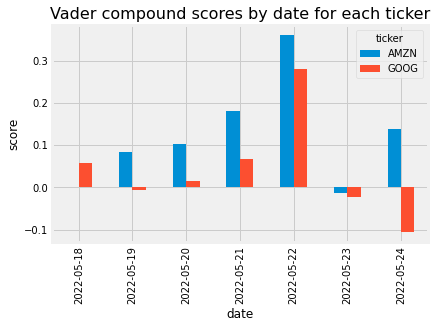

In [56]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
# Plot a bar chart with pandas
mean_c.plot.bar()
plt.title("Vader compound scores by date for each ticker", fontsize=16)
plt.ylabel("score")
plt.show()